In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
import faiss
import pickle as pkl
from tqdm import tqdm
import argparse
import h5py
from PIL import Image

In [2]:
def calculate_compactness(embeddings, labels):
    centroids = np.array([embeddings[labels == i].mean(axis = 0) for i in np.unique(labels)])
    distances = cdist(embeddings, centroids)
    return np.mean([distances[i, labels[i]] for i in range(len(labels))])

def calculate_compactness_faiss(embeddings, labels):
    unique_labels = np.unique(labels)
    centroids = np.array([embeddings[labels == i].mean(axis = 0) for i in unique_labels])
    print('Centroids calculated')
    
    d = embeddings.shape[1]
    index = faiss.IndexFlatL2(d)
    index.add(centroids)
    
    # get nearest centroids for each embedding
    distances, indices = index.search(embeddings, 1)
    nearest_centroid_distances = distances.squeeze()
    print('Found nearest centroids...')
    
    compactness = np.mean([nearest_centroid_distances[i] for i in range(len(labels)) if labels[i] == indices[i, 0]])

    return compactness


def calculate_wcss_faiss(embeddings, labels):
    unique_labels = np.unique(labels)
    centroids = np.array([embeddings[labels == i].mean(axis=0) for i in unique_labels])
    d = embeddings.shape[1]
    index = faiss.IndexFlatL2(d)
    index.add(centroids)
    distances, _ = index.search(embeddings, 1)
    nearest_centroid_distances = distances.squeeze()
    wcss = np.sum(nearest_centroid_distances ** 2)
    return wcss



In [3]:
data_root = '/raid/mpleasure/data_deepstorage/st_projects/visium/clustering_results/kmeans_organ_specific_clustering_90_10_split/ablations'

## COMBINE ACROSS K

In [4]:
tissue_type = 'Uterus'

all_files = sorted(glob.glob(os.path.join(data_root, f'k_*/{tissue_type}/{tissue_type}_coords_with_clusters.csv')))
all_files_centroids = sorted(glob.glob(os.path.join(data_root, f'k_*/{tissue_type}/{tissue_type}_centroids_image.npy')))

print(len(all_files), len(all_files_centroids))

file_centroid_dict = {}
for file in all_files_centroids:
    k = file.split('/')[-3]
    file_centroid_dict[k] = file

7 7


In [5]:
orig_df = None
for file in all_files:
    curr_df = pd.read_csv(file, index_col = 0)
    k = file.split('/')[-3]
    if k == "k_16":
        curr_df = curr_df.drop(columns = ['gene_prototype'])
        curr_df = curr_df.rename(columns = {'image_prototype': 'k_16'})
    else:
        curr_df = curr_df.rename(columns = {'image_prototype': k})
        
    if orig_df is None:
        orig_df = curr_df
    else:
        orig_df = orig_df.merge(curr_df, on = [
            'level_0',
            'id', 
            'bead', 'patch_x', 
            'patch_y', 'bead_center_x', 
            'bead_center_y', 'patch_x_obj', 'patch_y_obj'], how = 'left')

In [6]:
orig_df.to_csv(
    f'/raid/mpleasure/data_deepstorage/st_projects/visium/clustering_results/kmeans_organ_specific_clustering_90_10_split/ablations/combined/{tissue_type}_across_k.csv')

In [7]:
with open(
    f'/raid/mpleasure/data_deepstorage/st_projects/visium/clustering_results/kmeans_organ_specific_clustering_90_10_split/ablations/combined/{tissue_type}_centroids.pkl', 'wb') as f:
    pkl.dump(file_centroid_dict, f)

## COMBINED 

In [8]:
data_root = '/raid/mpleasure/data_deepstorage/st_projects/visium/clustering_results/kmeans_organ_specific_clustering_90_10_split/ablations/combined'
raw_embeds_root = '/raid/mpleasure/data_deepstorage/st_projects/visium/clustering_results/kmeans_organ_specific_clustering_90_10_split/ablations'

In [9]:
ks = [4, 8, 16, 32, 64, 96, 128]

In [19]:
wcss_dict = {}

### BLADDER

In [10]:
tissue_type = 'Bladder'
with open(os.path.join(data_root, f'{tissue_type}_centroids.pkl'), 'rb') as f:
    centroids_dict = pkl.load(f)
    
cluster_membership = pd.read_csv(os.path.join(data_root, f'{tissue_type}_across_k.csv'), index_col = 0)
image_embeds_raw = np.load(os.path.join(
    raw_embeds_root, f'{tissue_type}_image_embeds_raw.npy'))

In [11]:
print(len(centroids_dict), len(cluster_membership), image_embeds_raw.shape)

7 3069 (3069, 1024)


In [12]:
compactnesses = []
wcss_vals = []
for k in ks:
    labels = cluster_membership[f'k_{k}'].values
    compactness = calculate_compactness_faiss(image_embeds_raw, labels)
    wcss = calculate_wcss_faiss(image_embeds_raw, labels)
    compactnesses.append(compactness)
    wcss_vals.append(wcss)

Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...


In [13]:
max_compact = max(compactnesses)
compactnesses = [(compactness) for compactness in compactnesses]

In [20]:
wcss_dict[tissue_type] = wcss_vals

### BOWEL

In [21]:
tissue_type = 'Bowel'
with open(os.path.join(data_root, f'{tissue_type}_centroids.pkl'), 'rb') as f:
    centroids_dict = pkl.load(f)
    
cluster_membership = pd.read_csv(os.path.join(data_root, f'{tissue_type}_across_k.csv'), index_col = 0)
image_embeds_raw = np.load(os.path.join(
    raw_embeds_root, f'{tissue_type}_image_embeds_raw.npy'))

In [22]:
print(len(centroids_dict), len(cluster_membership), image_embeds_raw.shape)

7 77430 (77430, 1024)


In [23]:
compactnesses = []
wcss_vals = []
for k in ks:
    labels = cluster_membership[f'k_{k}'].values
    compactness = calculate_compactness_faiss(image_embeds_raw, labels)
    wcss = calculate_wcss_faiss(image_embeds_raw, labels)
    compactnesses.append(compactness)
    wcss_vals.append(wcss)

Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...


In [24]:
wcss_dict[tissue_type] = wcss_vals

### BREAST

In [25]:
tissue_type = 'Breast'
with open(os.path.join(data_root, f'{tissue_type}_centroids.pkl'), 'rb') as f:
    centroids_dict = pkl.load(f)
    
cluster_membership = pd.read_csv(os.path.join(data_root, f'{tissue_type}_across_k.csv'), index_col = 0)
image_embeds_raw = np.load(os.path.join(
    raw_embeds_root, f'{tissue_type}_image_embeds_raw.npy'))

print(len(centroids_dict), len(cluster_membership), image_embeds_raw.shape)

7 16993 (16993, 1024)


In [26]:
compactnesses = []
wcss_vals = []
for k in ks:
    labels = cluster_membership[f'k_{k}'].values
    compactness = calculate_compactness_faiss(image_embeds_raw, labels)
    wcss = calculate_wcss_faiss(image_embeds_raw, labels)
    compactnesses.append(compactness)
    wcss_vals.append(wcss)

Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...


In [27]:
wcss_dict[tissue_type] = wcss_vals

### CERVIX

In [28]:
tissue_type = 'Cervix'
with open(os.path.join(data_root, f'{tissue_type}_centroids.pkl'), 'rb') as f:
    centroids_dict = pkl.load(f)
    
cluster_membership = pd.read_csv(os.path.join(data_root, f'{tissue_type}_across_k.csv'), index_col = 0)
image_embeds_raw = np.load(os.path.join(
    raw_embeds_root, f'{tissue_type}_image_embeds_raw.npy'))

print(len(centroids_dict), len(cluster_membership), image_embeds_raw.shape)

7 7764 (7764, 1024)


In [29]:
compactnesses = []
wcss_vals = []
for k in ks:
    labels = cluster_membership[f'k_{k}'].values
    compactness = calculate_compactness_faiss(image_embeds_raw, labels)
    wcss = calculate_wcss_faiss(image_embeds_raw, labels)
    compactnesses.append(compactness)
    wcss_vals.append(wcss)

Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...


In [30]:
wcss_dict[tissue_type] = wcss_vals

### EYE

In [31]:
tissue_type = 'Eye'
with open(os.path.join(data_root, f'{tissue_type}_centroids.pkl'), 'rb') as f:
    centroids_dict = pkl.load(f)
    
cluster_membership = pd.read_csv(os.path.join(data_root, f'{tissue_type}_across_k.csv'), index_col = 0)
image_embeds_raw = np.load(os.path.join(
    raw_embeds_root, f'{tissue_type}_image_embeds_raw.npy'))

print(len(centroids_dict), len(cluster_membership), image_embeds_raw.shape)

7 4718 (4718, 1024)


In [32]:
compactnesses = []
wcss_vals = []
for k in ks:
    labels = cluster_membership[f'k_{k}'].values
    compactness = calculate_compactness_faiss(image_embeds_raw, labels)
    wcss = calculate_wcss_faiss(image_embeds_raw, labels)
    compactnesses.append(compactness)
    wcss_vals.append(wcss)

Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...


In [33]:
wcss_dict[tissue_type] = wcss_vals

### HEART

In [34]:
tissue_type = 'Heart'
with open(os.path.join(data_root, f'{tissue_type}_centroids.pkl'), 'rb') as f:
    centroids_dict = pkl.load(f)
    
cluster_membership = pd.read_csv(os.path.join(data_root, f'{tissue_type}_across_k.csv'), index_col = 0)
image_embeds_raw = np.load(os.path.join(
    raw_embeds_root, f'{tissue_type}_image_embeds_raw.npy'))

print(len(centroids_dict), len(cluster_membership), image_embeds_raw.shape)

7 4247 (4247, 1024)


In [35]:
compactnesses = []
wcss_vals = []
for k in ks:
    labels = cluster_membership[f'k_{k}'].values
    compactness = calculate_compactness_faiss(image_embeds_raw, labels)
    wcss = calculate_wcss_faiss(image_embeds_raw, labels)
    compactnesses.append(compactness)
    wcss_vals.append(wcss)

Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...


In [37]:
wcss_dict[tissue_type] = wcss_vals

### KIDNEY

In [39]:
tissue_type = 'Kidney'
with open(os.path.join(data_root, f'{tissue_type}_centroids.pkl'), 'rb') as f:
    centroids_dict = pkl.load(f)
    
cluster_membership = pd.read_csv(os.path.join(data_root, f'{tissue_type}_across_k.csv'), index_col = 0)
image_embeds_raw = np.load(os.path.join(
    raw_embeds_root, f'{tissue_type}_image_embeds_raw.npy'))

print(len(centroids_dict), len(cluster_membership), image_embeds_raw.shape)

7 44243 (44243, 1024)


In [40]:
compactnesses = []
wcss_vals = []
for k in ks:
    labels = cluster_membership[f'k_{k}'].values
    compactness = calculate_compactness_faiss(image_embeds_raw, labels)
    wcss = calculate_wcss_faiss(image_embeds_raw, labels)
    compactnesses.append(compactness)
    wcss_vals.append(wcss)

Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...


In [41]:
wcss_dict[tissue_type] = wcss_vals

### LIVER

In [42]:
tissue_type = 'Liver'
with open(os.path.join(data_root, f'{tissue_type}_centroids.pkl'), 'rb') as f:
    centroids_dict = pkl.load(f)
    
cluster_membership = pd.read_csv(os.path.join(data_root, f'{tissue_type}_across_k.csv'), index_col = 0)
image_embeds_raw = np.load(os.path.join(
    raw_embeds_root, f'{tissue_type}_image_embeds_raw.npy'))

print(len(centroids_dict), len(cluster_membership), image_embeds_raw.shape)

7 62165 (62165, 1024)


In [43]:
compactnesses = []
wcss_vals = []
for k in ks:
    labels = cluster_membership[f'k_{k}'].values
    compactness = calculate_compactness_faiss(image_embeds_raw, labels)
    wcss = calculate_wcss_faiss(image_embeds_raw, labels)
    compactnesses.append(compactness)
    wcss_vals.append(wcss)

Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...


In [44]:
wcss_dict[tissue_type] = wcss_vals

### LUNG

In [45]:
tissue_type = 'Lung'
with open(os.path.join(data_root, f'{tissue_type}_centroids.pkl'), 'rb') as f:
    centroids_dict = pkl.load(f)
    
cluster_membership = pd.read_csv(os.path.join(data_root, f'{tissue_type}_across_k.csv'), index_col = 0)
image_embeds_raw = np.load(os.path.join(
    raw_embeds_root, f'{tissue_type}_image_embeds_raw.npy'))

print(len(centroids_dict), len(cluster_membership), image_embeds_raw.shape)

7 58060 (58060, 1024)


In [46]:
compactnesses = []
wcss_vals = []
for k in ks:
    labels = cluster_membership[f'k_{k}'].values
    compactness = calculate_compactness_faiss(image_embeds_raw, labels)
    wcss = calculate_wcss_faiss(image_embeds_raw, labels)
    compactnesses.append(compactness)
    wcss_vals.append(wcss)

Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...


In [47]:
wcss_dict[tissue_type] = wcss_vals

### LYMPH NODE

In [48]:
tissue_type = 'Lymph node'
with open(os.path.join(data_root, f'{tissue_type}_centroids.pkl'), 'rb') as f:
    centroids_dict = pkl.load(f)
    
cluster_membership = pd.read_csv(os.path.join(data_root, f'{tissue_type}_across_k.csv'), index_col = 0)
image_embeds_raw = np.load(os.path.join(
    raw_embeds_root, f'{tissue_type}_image_embeds_raw.npy'))

print(len(centroids_dict), len(cluster_membership), image_embeds_raw.shape)

7 80852 (80852, 1024)


In [49]:
compactnesses = []
wcss_vals = []
for k in ks:
    labels = cluster_membership[f'k_{k}'].values
    compactness = calculate_compactness_faiss(image_embeds_raw, labels)
    wcss = calculate_wcss_faiss(image_embeds_raw, labels)
    compactnesses.append(compactness)
    wcss_vals.append(wcss)

Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...


In [50]:
wcss_dict[tissue_type] = wcss_vals

### OVARY

In [51]:
tissue_type = 'Ovary'
with open(os.path.join(data_root, f'{tissue_type}_centroids.pkl'), 'rb') as f:
    centroids_dict = pkl.load(f)
    
cluster_membership = pd.read_csv(os.path.join(data_root, f'{tissue_type}_across_k.csv'), index_col = 0)
image_embeds_raw = np.load(os.path.join(
    raw_embeds_root, f'{tissue_type}_image_embeds_raw.npy'))

print(len(centroids_dict), len(cluster_membership), image_embeds_raw.shape)

7 8125 (8125, 1024)


In [52]:
compactnesses = []
wcss_vals = []
for k in ks:
    labels = cluster_membership[f'k_{k}'].values
    compactness = calculate_compactness_faiss(image_embeds_raw, labels)
    wcss = calculate_wcss_faiss(image_embeds_raw, labels)
    compactnesses.append(compactness)
    wcss_vals.append(wcss)

Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...


In [53]:
wcss_dict[tissue_type] = wcss_vals

### PANCREAS

In [55]:
tissue_type = 'Lymph node'
with open(os.path.join(data_root, f'{tissue_type}_centroids.pkl'), 'rb') as f:
    centroids_dict = pkl.load(f)
    
cluster_membership = pd.read_csv(os.path.join(data_root, f'{tissue_type}_across_k.csv'), index_col = 0)
image_embeds_raw = np.load(os.path.join(
    raw_embeds_root, f'{tissue_type}_image_embeds_raw.npy'))

print(len(centroids_dict), len(cluster_membership), image_embeds_raw.shape)

7 80852 (80852, 1024)


In [56]:
compactnesses = []
wcss_vals = []
for k in ks:
    labels = cluster_membership[f'k_{k}'].values
    compactness = calculate_compactness_faiss(image_embeds_raw, labels)
    wcss = calculate_wcss_faiss(image_embeds_raw, labels)
    compactnesses.append(compactness)
    wcss_vals.append(wcss)

Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...


In [57]:
wcss_dict[tissue_type] = wcss_vals

### PROSTATE

In [58]:
tissue_type = 'Prostate'
with open(os.path.join(data_root, f'{tissue_type}_centroids.pkl'), 'rb') as f:
    centroids_dict = pkl.load(f)
    
cluster_membership = pd.read_csv(os.path.join(data_root, f'{tissue_type}_across_k.csv'), index_col = 0)
image_embeds_raw = np.load(os.path.join(
    raw_embeds_root, f'{tissue_type}_image_embeds_raw.npy'))

print(len(centroids_dict), len(cluster_membership), image_embeds_raw.shape)

7 93765 (93765, 1024)


In [59]:
compactnesses = []
wcss_vals = []
for k in ks:
    labels = cluster_membership[f'k_{k}'].values
    compactness = calculate_compactness_faiss(image_embeds_raw, labels)
    wcss = calculate_wcss_faiss(image_embeds_raw, labels)
    compactnesses.append(compactness)
    wcss_vals.append(wcss)

Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...


In [60]:
wcss_dict[tissue_type] = wcss_vals

### SKIN

In [62]:
tissue_type = 'Skin'
with open(os.path.join(data_root, f'{tissue_type}_centroids.pkl'), 'rb') as f:
    centroids_dict = pkl.load(f)
    
cluster_membership = pd.read_csv(os.path.join(data_root, f'{tissue_type}_across_k.csv'), index_col = 0)
image_embeds_raw = np.load(os.path.join(
    raw_embeds_root, f'{tissue_type}_image_embeds_raw.npy'))

print(len(centroids_dict), len(cluster_membership), image_embeds_raw.shape)

7 56307 (56307, 1024)


In [63]:
compactnesses = []
wcss_vals = []
for k in ks:
    labels = cluster_membership[f'k_{k}'].values
    compactness = calculate_compactness_faiss(image_embeds_raw, labels)
    wcss = calculate_wcss_faiss(image_embeds_raw, labels)
    compactnesses.append(compactness)
    wcss_vals.append(wcss)

Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...


In [65]:
wcss_dict[tissue_type] = wcss_vals

### UTERUS

In [66]:
tissue_type = 'Uterus'
with open(os.path.join(data_root, f'{tissue_type}_centroids.pkl'), 'rb') as f:
    centroids_dict = pkl.load(f)
    
cluster_membership = pd.read_csv(os.path.join(data_root, f'{tissue_type}_across_k.csv'), index_col = 0)
image_embeds_raw = np.load(os.path.join(
    raw_embeds_root, f'{tissue_type}_image_embeds_raw.npy'))

print(len(centroids_dict), len(cluster_membership), image_embeds_raw.shape)

7 3348 (3348, 1024)


In [67]:
compactnesses = []
wcss_vals = []
for k in ks:
    labels = cluster_membership[f'k_{k}'].values
    compactness = calculate_compactness_faiss(image_embeds_raw, labels)
    wcss = calculate_wcss_faiss(image_embeds_raw, labels)
    compactnesses.append(compactness)
    wcss_vals.append(wcss)

Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...
Centroids calculated
Found nearest centroids...


In [69]:
wcss_dict[tissue_type] = wcss_vals

In [71]:
len(wcss_dict.keys())

14

In [73]:
wcss_df = pd.DataFrame(wcss_dict)
wcss_df

,Bladder,Bowel,Breast,Cervix,Eye,Heart,Kidney,Liver,Lung,Lymph node,Ovary,Prostate,Skin,Uterus
0,1.148849e+09,8.270057e+10,1.368744e+10,4.248080e+09,2.118343e+09,633273856.0,2.058224e+10,3.715841e+10,5.981071e+10,7.741379e+10,4.581181e+09,8.508730e+10,4.451509e+10,1.606583e+09
1,8.450510e+08,6.684835e+10,9.881925e+09,3.234074e+09,1.743755e+09,529770240.0,1.674550e+10,2.375924e+10,4.566274e+10,6.324632e+10,3.524509e+09,6.675365e+10,3.693707e+10,1.283921e+09
2,6.753860e+08,5.189333e+10,7.567606e+09,2.494329e+09,1.463731e+09,449278048.0,1.421504e+10,1.801038e+10,3.680006e+10,5.111443e+10,2.857011e+09,5.334352e+10,2.905684e+10,1.031952e+09
3,5.446637e+08,4.072576e+10,6.194996e+09,2.017230e+09,1.207769e+09,384949504.0,1.194238e+10,1.413218e+10,2.954194e+10,4.075978e+10,2.433099e+09,4.366720e+10,2.409454e+10,8.213492e+08
4,4.457890e+08,3.325343e+10,4.973885e+09,1.669963e+09,1.010941e+09,336981792.0,1.014090e+10,1.142796e+10,2.416148e+10,3.336904e+10,2.101089e+09,3.592271e+10,1.946972e+10,6.742378e+08
5,3.989434e+08,2.974113e+10,4.410457e+09,1.486886e+09,9.193078e+08,309897312.0,9.251948e+09,1.008520e+10,2.149772e+10,2.947148e+10,1.894670e+09,3.237299e+10,1.751848e+10,6.041239e+08
6,3.671366e+08,2.750943e+10,4.099941e+09,1.373527e+09,8.438821e+08,291557568.0,8.586856e+09,9.524327e+09,1.976864e+10,2.746277e+10,1.787160e+09,3.020114e+10,1.637993e+10,5.507270e+08


In [81]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_feats = scaler.fit_transform(wcss_df.values)
scaled_df = pd.DataFrame(scaled_feats, columns = wcss_df.columns)
scaled_df

,Bladder,Bowel,Breast,Cervix,Eye,Heart,Kidney,Liver,Lung,Lymph node,Ovary,Prostate,Skin,Uterus
0,1.970346,1.826390,1.993950,1.932757,1.807780,1.834736,1.848021,2.112243,1.912632,1.800715,1.965459,1.890748,1.795373,1.841377
1,0.811617,1.003320,0.813484,0.894435,0.949150,0.946875,0.904628,0.655627,0.868608,0.985496,0.837575,0.913355,1.025055,0.951406
2,0.164490,0.226833,0.095585,0.136952,0.307281,0.256408,0.282430,0.030672,0.214603,0.287407,0.125092,0.198441,0.224015,0.256424
3,-0.334104,-0.353005,-0.330197,-0.351588,-0.279432,-0.295406,-0.276381,-0.390926,-0.320998,-0.308416,-0.327389,-0.317417,-0.280412,-0.324464
4,-0.711227,-0.740979,-0.708984,-0.707181,-0.730602,-0.706876,-0.719335,-0.684900,-0.718039,-0.733691,-0.681774,-0.730287,-0.750534,-0.730229
5,-0.889903,-0.923343,-0.883758,-0.894649,-0.940643,-0.939209,-0.937914,-0.830871,-0.914606,-0.957963,-0.902104,-0.919528,-0.948881,-0.923618
6,-1.011218,-1.039216,-0.980080,-1.010726,-1.113533,-1.096528,-1.101449,-0.891843,-1.042200,-1.073548,-1.016859,-1.035312,-1.064616,-1.070897


In [82]:
ks

[4, 8, 16, 32, 64, 96, 128]

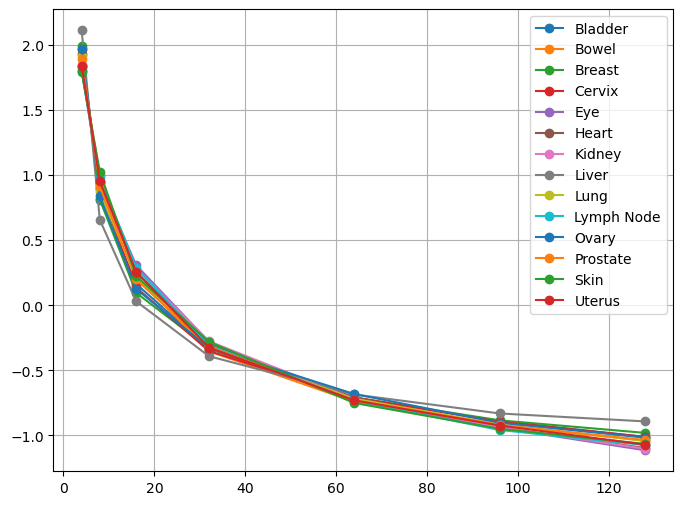

In [86]:
plt.figure(figsize = (8, 6))
plt.plot(ks, scaled_df['Bladder'].values, marker = 'o', label = 'Bladder')
plt.plot(ks, scaled_df['Bowel'].values, marker = 'o', label = 'Bowel')
plt.plot(ks, scaled_df['Breast'].values, marker = 'o', label = 'Breast')
plt.plot(ks, scaled_df['Cervix'].values, marker = 'o', label = 'Cervix')
plt.plot(ks, scaled_df['Eye'].values, marker = 'o', label = 'Eye')
plt.plot(ks, scaled_df['Heart'].values, marker = 'o', label = 'Heart')
plt.plot(ks, scaled_df['Kidney'].values, marker = 'o', label = 'Kidney')
plt.plot(ks, scaled_df['Liver'].values, marker = 'o', label = 'Liver')
plt.plot(ks, scaled_df['Lung'].values, marker = 'o', label = 'Lung')
plt.plot(ks, scaled_df['Lymph node'].values, marker = 'o', label = 'Lymph Node')
plt.plot(ks, scaled_df['Ovary'].values, marker = 'o', label = 'Ovary')
plt.plot(ks, scaled_df['Prostate'].values, marker = 'o', label = 'Prostate')
plt.plot(ks, scaled_df['Skin'].values, marker = 'o', label = 'Skin')
plt.plot(ks, scaled_df['Uterus'].values, marker = 'o', label = 'Uterus')
plt.legend()
plt.grid(True)
plt.show()

In [100]:
colors = [
  "#000000", # Black
  "#E69F00", # Orange
  "#56B4E9", # Sky Blue
  "#009E73", # Bluish Green
  "#F0E442", # Yellow
  "#0072B2", # Blue
  "#D55E00", # Vermillion
  "#CC79A7"  # Reddish Purple
]
line_styles = ["-", ":"]

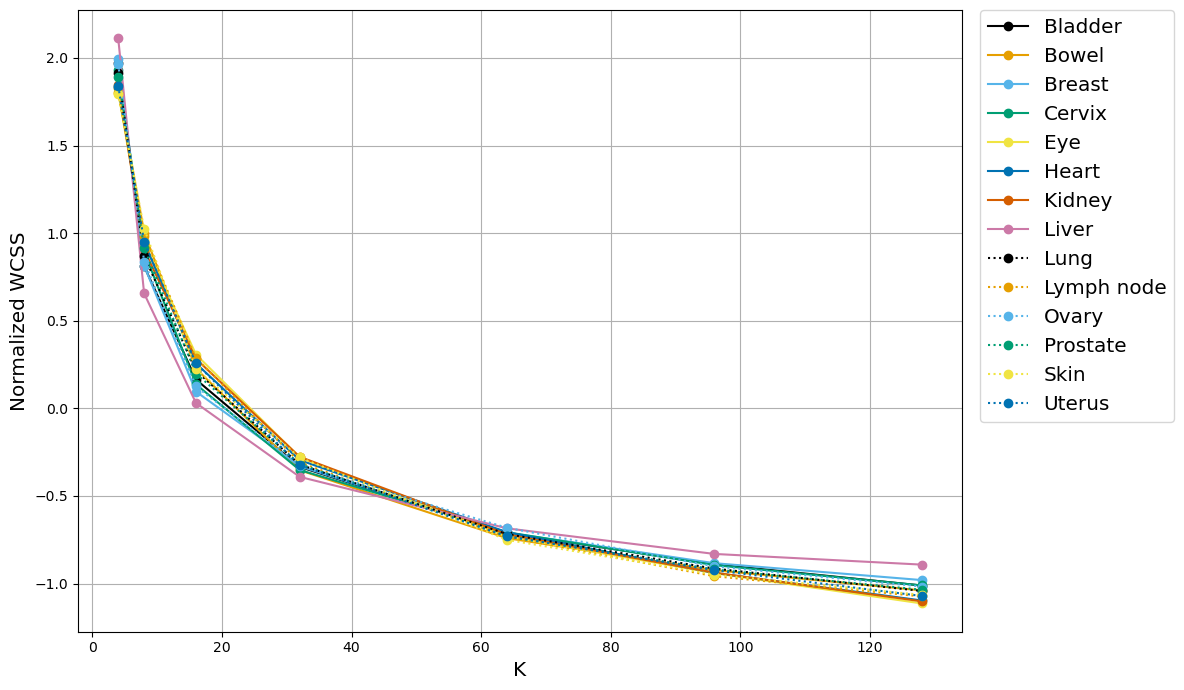

In [112]:
plt.figure(figsize = (15, 7))
for i, tissue in enumerate(scaled_df.columns):
    # Determine color by cycling through 'colors'
    c = colors[i % len(colors)]
    # Determine line style by how many times we've cycled through colors
    ls = line_styles[i // len(colors)]
    plt.plot(ks,
       scaled_df[tissue].values,
       label=tissue,
       color=c,
       linestyle=ls,
       marker='o')
    
plt.grid(True)
plt.legend(ncol = 1, fontsize = 'x-large', bbox_to_anchor = (1.02, 1), loc = 'upper left', borderaxespad=0)
plt.xlabel('K', fontsize = 'x-large')
plt.ylabel('Normalized WCSS', fontsize = 'x-large')
plt.tight_layout(rect = ([0, 0, 0.8, 1]))
plt.savefig(os.path.join('/raid/mpleasure/data_deepstorage/st_projects/visualizations', 'clustering_lower_level.png'))